In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier

# Get the data

Read the data in as a dataframe using pandas. The data file is called: "African_data.txt". The data include [bioclimatic variables](https://www.worldclim.org/data/bioclim.html) (the average and standard deviation across a species' range), the minimum and maximum latitude and longitude of the species range, and the area of the species range.

In [2]:
Africa_data = pd.read_csv("Africa_data.txt", sep="\t", header=0)
Africa_data.head()

/var/folders/vd/vcj9qv6d4530cj69kl9cw9kr0000gq/T/ipykernel_52471/1785287719.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  Africa_data = pd.read_csv("Africa_data.txt", sep="\t", header=0)


,name,n.gps,abs_max_lat,abs_min_lat,length_lat,median_lon,median_lat,area,bio1m,bio1sd,...,bio17sd,bio18m,bio18sd,bio19m,bio19sd,elevm,elevsd,continents,dist,Red.List.status
0,Aaronsohnia pubescens,31,35.166667,26.150000,9.016667,-6.317847,31.450001,8.471561e+11,179.645161,21.021494,...,9.050634,14.032258,8.734926,67.806452,45.120889,104.870968,72.551472,"Africa,Europe",global,NaN
1,Abelmoschus esculentus,37,16.016667,25.670000,41.686667,11.516667,6.866667,1.608146e+13,256.918919,30.402283,...,37.179158,272.243243,207.168531,335.540541,478.145468,145.351351,68.946121,"Africa,Asia,Europe,Australia,South America and...",global,NaN
2,Abelmoschus ficulneus,5,15.125000,16.966670,32.091670,37.033333,5.350000,3.643061e+11,270.800000,12.029131,...,25.812788,307.400000,312.333636,142.200000,267.300767,104.400000,59.672439,"Africa,Asia,NA,Australia",global,NaN
3,Abelmoschus manihot,11,9.350000,22.025600,31.375600,11.450000,4.150000,2.084726e+12,236.454545,26.526830,...,42.956849,294.727273,107.079495,596.545455,471.006659,134.636364,68.026866,"Africa,Asia,NA,Australia,South America and the...",global,NaN
4,Abelmoschus moschatus,19,31.182780,16.333333,47.516113,2.550000,6.490000,1.757908e+13,247.947368,51.744537,...,100.923832,369.052632,325.903782,286.526316,246.123359,137.894737,85.452322,"Africa,NA,Asia,Europe,Australia,South America ...",global,NaN


# Change Red List Status labelling and remove some rows

The below code will just modify the response variable to match the categories used in the paper (e.g., the table lists Near Threatened species as (LR/nt) and vulnurable species as (LR/cd) where cd stands for conservation dependent.)

We also remove rows with no red list status defined, and rows where there were fewer than four GPS points.

In [3]:
# Condition to identify rows where 'Red.List.status' is "LR/nt" (near threatened)
condition = Africa_data['Red.List.status'] == "LR/nt"

# Modify the values based on the condition
Africa_data.loc[condition, 'Red.List.status'] = "NT"

# Condition to identify rows where 'Red.List.status' is "LR/nt" (conservation dependent)
condition = Africa_data['Red.List.status'] == "LR/cd"

# Modify the values based on the condition
Africa_data.loc[condition, 'Red.List.status'] = "VU"

# Condition to identify rows where 'Red.List.status' is "LR/nt" (least concern)
condition = Africa_data['Red.List.status'] == "LR/lc"

# Modify the values based on the condition
Africa_data.loc[condition, 'Red.List.status'] = "LC"

# remove rows without a defined red list status
filtered_Africa_data = Africa_data.dropna(subset=['Red.List.status'])

# remove rows with fewer than 4 samples
filtered_Africa_data = filtered_Africa_data[filtered_Africa_data['n.gps'] >= 4]

# Check how many observations belong in each category

The classifiers may not perform well when we have different numbers of observations in each category.

In [4]:
status_counts = filtered_Africa_data['Red.List.status'].value_counts().reset_index()

# Rename the columns for clarity
status_counts.columns = ['Red List Status', 'Count']

# Display the table
print(status_counts)

  Red List Status  Count
0              LC    984
1              VU    543
2              EN    388
3              NT    166
4              CR    114
5              DD     51


# Add variable indicating whether a species is LC or not LC

Notice that we have the most observations for least concern (LC). The authors of this paper decided to only try to predict whether a species was least concern or not. Below, we add a response column that only includes 'LC' and 'NonLC'.

In [5]:
filtered_Africa_data['Response'] = np.where(filtered_Africa_data['Red.List.status'] == 'LC', 'LC', 'NonLC')

# Prepare dataset for training

Next, we prepare our dataset for training by removing columns that we won't use, separating out our labels and features, and splitting the data into training and testing sets.

In [6]:
# List of columns to remove
columns_to_remove = ['name', 'n.gps', 'continents', 'dist', 'Red.List.status']

# Removing columns using drop()
X = filtered_Africa_data.drop(columns=columns_to_remove)

# separe labels and features
y = X['Response']
X = X.drop('Response', axis=1)
X.head()

# Split the dataset into training, testing, and validation sets
# NOTE: DO NOT CHANGE THESE RANDOM_STATE VARIABLES
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)


# Scale

Let's scale our features to put everything on the same scale (this can be important when evaluating feature importance.)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# Train the Random Forest Classifier, and check the out of bag score.

The out of bag score is the accuracy, not the error. To get the error, subtract this from one.

**Change**: Try changing the number of estimators (i.e., trees) and explore how this impacts accuracy.

In [8]:
randomforest = RandomForestClassifier(n_estimators=10, oob_score=True)
randomforest.fit(X_train_scaled, y_train)
print(randomforest.oob_score_)

0.7600950118764845


/Users/megan/miniforge3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


# Make Predictions on the Training and Testing Data

Use the trained classifier to make predictions on our training and testing data.

**Add**: Add code to make predictions and assess performance on the test data. Include accuracy and a confusion matrix.

Accuracy on training data: 0.99


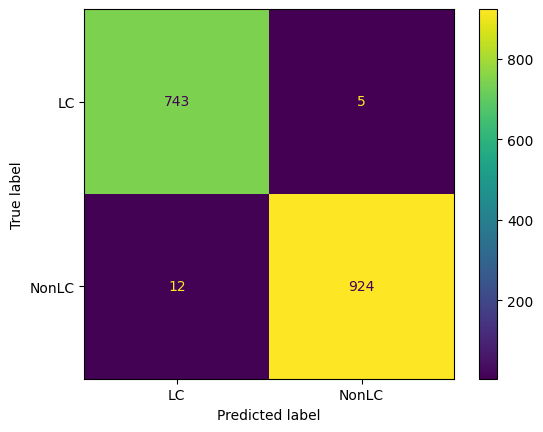

In [9]:
# Make predictions
y_pred_train = randomforest.predict(X_train_scaled)

# Evaluate the Model
accuracy_train = accuracy_score(y_train, y_pred_train)

print(f'Accuracy on training data: {accuracy_train:.2f}')
ConfusionMatrixDisplay.from_estimator(
    randomforest, X_train_scaled, y_train)



# Calculate variable importance.

Below, we calculate feature importance using GINI impurity and using permutation-based variable importance.

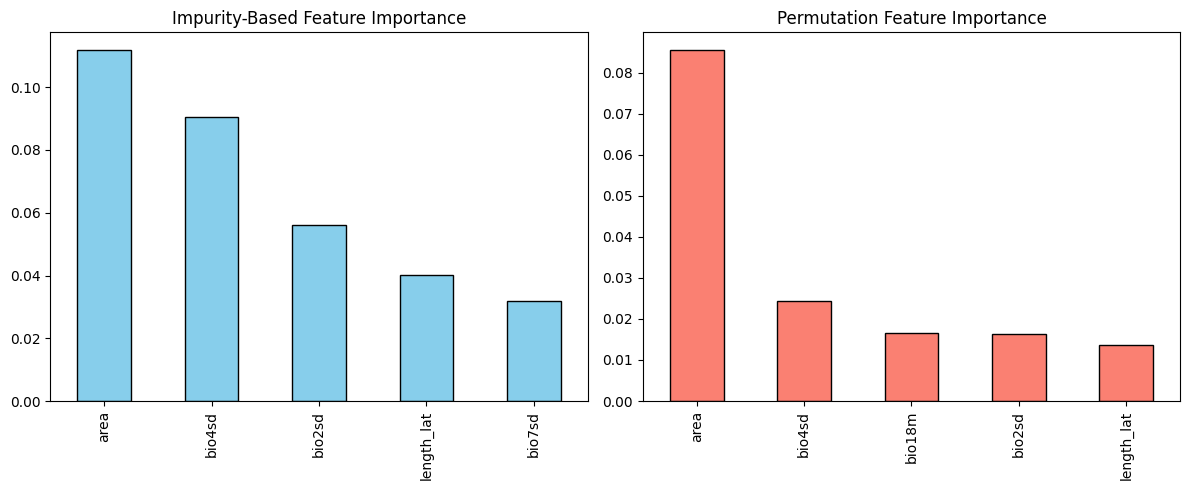

In [10]:
# Calculate impurity variable importance
feature_importances = pd.Series(randomforest.feature_importances_, index=X_train.columns).sort_values(ascending=False)[0:5]

# Calculate permutation-based variable importance
permutation_feature_importances = permutation_importance(randomforest, X_train_scaled, y_train,
                                        n_repeats=30,
                                        random_state=0)

plot_permutation_feature_importances = pd.Series(permutation_feature_importances['importances_mean'], index=X_train.columns).sort_values(ascending=False)[0:5]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot impurity-based feature importance
feature_importances.plot.bar(ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Impurity-Based Feature Importance')

# Plot permutation feature importance
plot_permutation_feature_importances.plot.bar(ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Permutation Feature Importance')

plt.tight_layout()
plt.show()


# Try it using AdaBoost

This code will do the same as above, but with AdaBoost!

**Add**: Add code to make predictions and assess performance on the test data. Include accuracy and a confusion matrix.

**Change**: Try changing the number of estimators (i.e., trees) and explore how this impacts accuracy. **Use the test error to evaluate!**

Accuracy on training data: 0.78


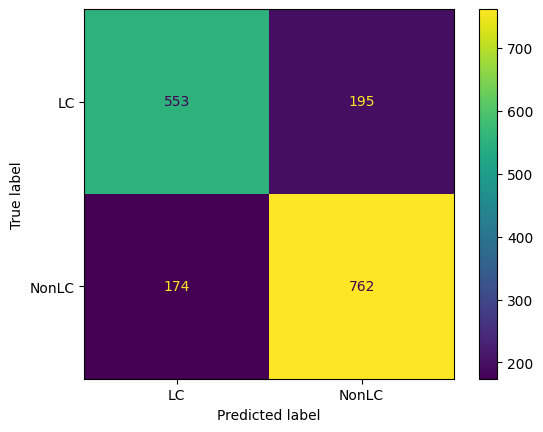

In [11]:
ada = AdaBoostClassifier(estimator=None, n_estimators=10, learning_rate=1.0, random_state=None)
ada.fit(X_train_scaled, y_train)

# Make predictions
ada_y_pred_train = ada.predict(X_train_scaled)

# Evaluate the Model
ada_accuracy_train = accuracy_score(y_train, ada_y_pred_train)

print(f'Accuracy on training data: {ada_accuracy_train:.2f}')


ConfusionMatrixDisplay.from_estimator(
    ada, X_train_scaled, y_train)



# Feature importances for AdaBoost

Below, we calculate feature importance using GINI impurity and using permutation-based variable importance.

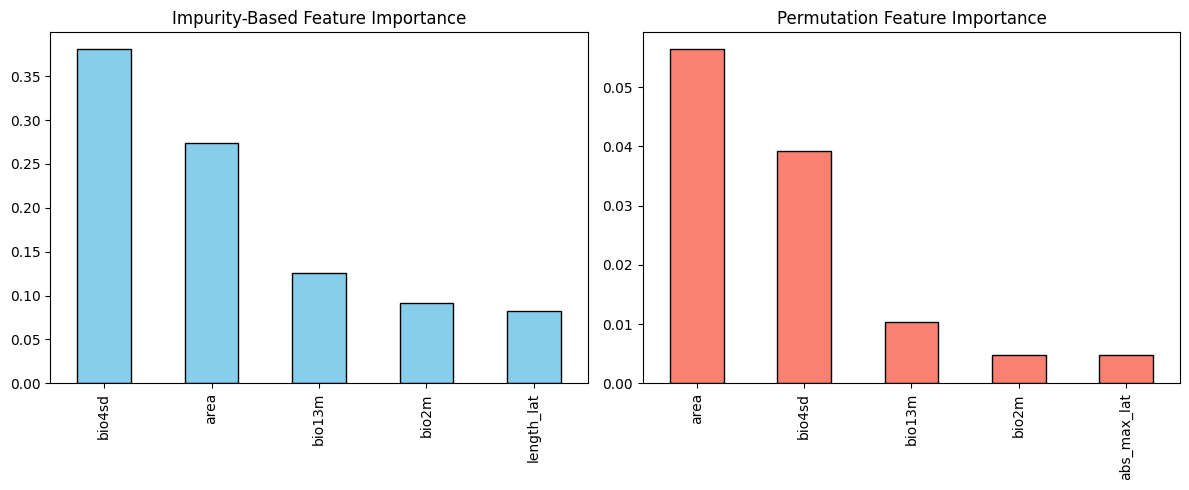

In [12]:
# Calculate impurity variable importance
ada_feature_importances = pd.Series(ada.feature_importances_, index=X_train.columns).sort_values(ascending=False)[0:5]

# Calculate permutation-based variable importance
ada_permutation_feature_importances = permutation_importance(ada, X_train_scaled, y_train,
                                        n_repeats=30,
                                        random_state=0)

ada_plot_permutation_feature_importances = pd.Series(ada_permutation_feature_importances['importances_mean'], index=X_train.columns).sort_values(ascending=False)[0:5]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot impurity-based feature importance
ada_feature_importances.plot.bar(ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Impurity-Based Feature Importance')

# Plot permutation feature importance
ada_plot_permutation_feature_importances.plot.bar(ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Permutation Feature Importance')

plt.tight_layout()
plt.show()


# (6990 only) You try it! Do the same analyses as above, but use the all of the categories, instead of just Least Concern or Non-Least Concern.

**Note**: You can choose whether to use AdaBoost or Random Forest!

**Hint**: Instead of using "Response" as your variable, use "Red.List.status"!